In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

import torch
from torch.autograd import Variable


Below we study a stochastic function $f_t(x)$, identical to the one demonstrated in *On the Convergence of Adam and Beyond*:

$f_t(x,y) = \begin{cases} 
    1010x + 1010y & \textrm{with probability 0.01} \\
    -10x -10y & \textrm{otherwise}
\end{cases}$

In [205]:
def f_t(x,y):
    c = np.random.choice([1010,-10], p=[0.01,0.99])
    return c*x + c*y

# Beale's function
# f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
f = lambda x,y: (1010*x+1010*y)*0.01 - (10*x+10*y)*0.99 ## deterministic 2d version of function in paper


In [208]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

# minima = np.array([3., .5])
minima = np.array([-1., -1.])

minima_ = minima.reshape(-1, 1)
minima_

array([[-1.],
       [-1.]])

In [209]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x,y)

In [210]:
f(-1,-1)

-0.3999999999999986

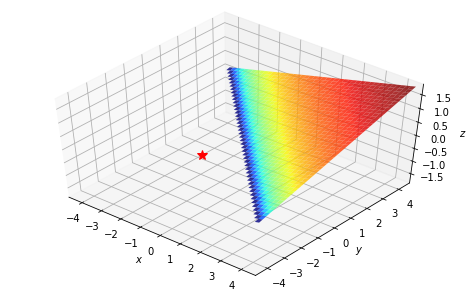

In [211]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [212]:
x0 = np.array([3., 4.])

In [213]:
dtype = torch.FloatTensor
w = Variable(torch.FloatTensor(x0), requires_grad=True)

optimizer = torch.optim.Adam([w], lr = 1e-3)

In [230]:
def var_ft(x,y):
    c = np.random.choice([1010,-10], p=[0.01,0.99])
    c = np.array([float(c)])
    c = Variable(torch.FloatTensor(c))
    return (c*x + c*y)

def beales(var):
    x = var[0]
    y = var[1]
    
#     return ((1.5 - x + x*y).pow(2) + (2.25 - x + (x*y).pow(2)).pow(2) + (2.625 - x + (x*y).pow(3)).pow(2))
    return var_ft(x,y)

In [231]:
def closure():
    optimizer.zero_grad()
    loss = beales(w)
    loss.backward()
    return loss
optimizer.step(closure)

Variable containing:
-27.0992
[torch.FloatTensor of size 1]

In [232]:
def optimize(optim, closure, w, steps, length):
    path = np.ndarray(shape=(steps,2),dtype=float)
    for step in range(steps):
        optim.step(closure)
        path[step][0] = w[0].data[0]
        path[step][1] = w[1].data[0]
    result = np.ndarray(shape=(length,2),dtype=float)
    idx = 0
    for n in np.linspace(0,steps-1,num=length, dtype=int):
        result[idx] = path[n]
        idx += 1
    return result

In [233]:
path = optimize(optimizer,closure,w,100000, 100).T

In [234]:
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(f, argnum=1)(x, y)

/usr/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


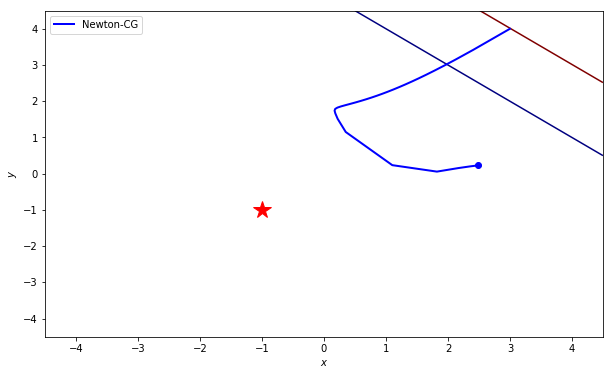

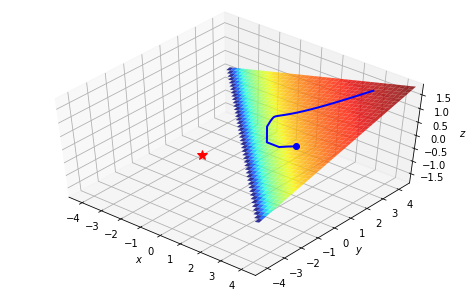

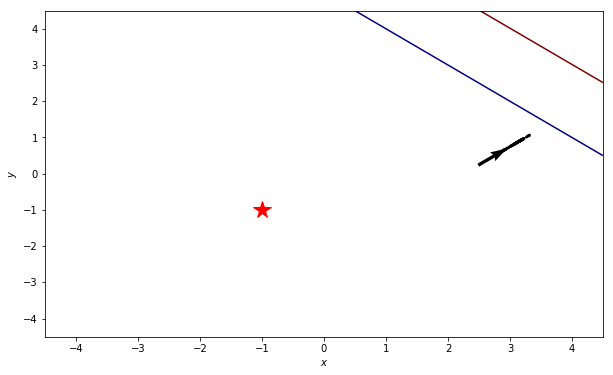

In [235]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [236]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

/usr/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


In [237]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

In [238]:
def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

In [239]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [240]:
HTML(anim.to_html5_video())

In [241]:
fig_3d = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

line_3d, = ax.plot([], [], [], 'b', label='Newton-CG', lw=2)
point_3d, = ax.plot([], [], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

(-4.5, 4.5)

In [242]:
def init_3d():
    line_3d.set_data([], [])
    line_3d.set_3d_properties([])
    point_3d.set_data([], [])
    point_3d.set_3d_properties([])
    return line, point

In [243]:
def animate_3d(i):
    line_3d.set_data(path[0,:i], path[1,:i])
    line_3d.set_3d_properties(f(*path[::,:i]))
    point_3d.set_data(path[0,i-1:i], path[1,i-1:i])
    point_3d.set_3d_properties(f(*path[::,i-1:i]))
    return line, point

In [244]:
anim = animation.FuncAnimation(fig_3d, animate_3d, init_func=init_3d,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [245]:
HTML(anim.to_html5_video())